# Recreation of Figure 6
Distribution of interaction path lengths between legal entities. 

### 1. Load the raw paths

In [2]:
import json
import itertools

# Load actual paths from file
with open("PathsList.json", "r") as fp:
    PATHS_LIST = json.load(fp)    
print("Raw Paths:", len(PATHS_LIST))

# Remove duplicate paths
TMP_PATHS = []
for p in PATHS_LIST:
    for l in PATHS_LIST[p]['paths']:
        TMP_PATHS.append(l)
        
print("TOTAL OVERALL PATHS:", len(TMP_PATHS))

# Print the overall unique max paths
TMP_PATHS.sort()
UN_MAX = list(TMP_PATHS for TMP_PATHS,_ in itertools.groupby(TMP_PATHS))
print("UNIQUE PATHS:", len(UN_MAX))

Raw Paths: 143271
TOTAL OVERALL PATHS: 1121636
UNIQUE PATHS: 62418


In [3]:
# Calculate the source and destination pairs keys and the paths to check against shortest paths
TMP_Pairs_set = {}

TOTAL_NODES = set()

for e in UN_MAX:
    key = e[0] + " " + e[-1]
    
    if key not in TMP_Pairs_set:
        TMP_Pairs_set[key] = []
    TMP_Pairs_set[key].append(e)
    
    for n in e:
        TOTAL_NODES.add(n)
    
print("TMP_Pairs_set:", len(TMP_Pairs_set), "TOTAL_NODES:", len(TOTAL_NODES))

TMP_Pairs_set: 50855 TOTAL_NODES: 9758


In [4]:
# Build the original graph
import pandas as pd
import networkx as nx


f_name = "../Datasets/EdgeList_Legal_Entities.txt"

# To hold the node links
links = []

with open(f_name, "r") as fp:
    for l in fp.readlines():
        line = l.strip().split(" ")
        links.append({
            "source": line[0],
            "target": line[1]
        })
print("# of Links:", len(links))

from_n = []
to_n = []

for l in links:
    from_n.append(l["source"])
    to_n.append(l["target"])
print("From: {}, To: {}".format(len(from_n), len(to_n)))

# Build a dataframe with 4 connections
df = pd.DataFrame({'from':from_n, 'to':to_n})

# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to')
print("# of Nodes:", len(G.nodes))

# of Links: 5920
From: 5920, To: 5920
# of Nodes: 1215


In [5]:
# Exclude all actual paths that include a node that is not present in the actual graph (mostly the actual visited website)
Pairs_set = {}
G_nodes = set(G.nodes)

for p in  TMP_Pairs_set: # For each key pair
    v_paths = [] # To hold the valid paths
    for e in TMP_Pairs_set[p]: # For each path in the key pair
        valid = True
        for n in e: # For each node in the path
            if n not in G_nodes:
                valid = False
                break
        if valid:
            v_paths.append(e)
    if len(v_paths) > 0:
        Pairs_set[p] = v_paths
print("# of clean paths: {}".format(len(Pairs_set)))

# of clean paths: 7890


### 2. Create the statistics, that is, the number of paths per hops length

In [6]:
Stats = {}

for k in Pairs_set:
    for p in Pairs_set[k]:
        key = len(p) - 1
        if key not in Stats:
            Stats[key] = 0
        Stats[key] += 1
        
print(json.dumps(Stats, indent=2))
print("Sum:", sum(Stats.values()))
print("Unique pairs: {}".format(len(Pairs_set)))

{
  "1": 6235,
  "2": 3864,
  "3": 610,
  "4": 38
}
Sum: 10747
Unique pairs: 7890


In [7]:
#### Estimate average hops for all actual paths
dist_h = []
last_max = len(dist_h)
for h in Stats:
    for i in range(Stats[h]):
        dist_h.append(h)
    print(h, Stats[h], len(dist_h) - last_max)
    last_max = len(dist_h)
print("Average hops: {:.2f}".format(sum(dist_h) / len(dist_h)))

1 6235 6235
2 3864 3864
3 610 610
4 38 38
Average hops: 1.48


### 3. Prepare data and plot them.

In [8]:
# Prepare datset for plot
all_s = sum(Stats.values())

elabels = []
evalues = []

for k in Stats:
    elabels.append(k)
    evalues.append(Stats[k] / all_s)

print("# of labels: {}\n#of values: {}".format(len(elabels), len(evalues)))

# of labels: 4
#of values: 4


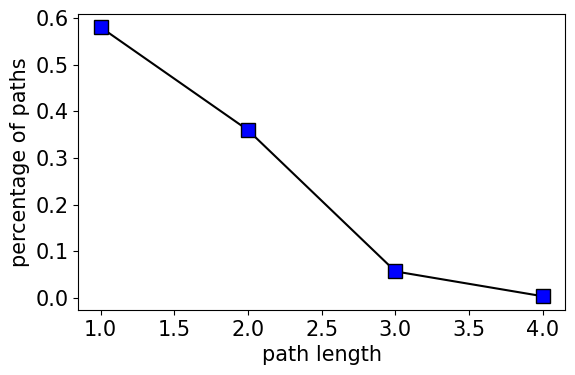

In [9]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

font = {'family': 'DejaVu Sans',
        'weight': 'normal',
        'size'  : 15}
matplotlib.rc('font', **font)

markerSize = 10
pp = PdfPages("Actual_Paths_Count_pdf_ALL.pdf")

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
plt.plot(elabels, evalues, 'ks-', markevery=1, linestyle='solid', markersize=markerSize, markerfacecolor="b", markeredgewidth=1.0, markeredgecolor="black", label="EPDF")
ax.ticklabel_format(style='plain')
plt.xlabel('path length')
plt.ylabel('percentage of paths')

plt.tight_layout()
plt.savefig(pp, format='pdf')
pp.close()

### 4. Estimate shortest paths

In [10]:
# Build the original graph
import pandas as pd
import numpy as np
import networkx as nx

links = []

with open("../Datasets/EdgeList_Legal_Entities.txt", "r") as fp:
    for l in fp.readlines():
        line = l.strip().split(" ")
        links.append({
            "source": line[0],
            "target": line[1]
        })
print(len(links))

from_n = []
to_n = []

for l in links:
    from_n.append(l["source"])
    to_n.append(l["target"])
print("From: {}, To: {}".format(len(from_n), len(to_n)))

# Build a dataframe
df = pd.DataFrame({'from':from_n, 'to':to_n})

# Build the graph
G=nx.from_pandas_edgelist(df, 'from', 'to')

5920
From: 5920, To: 5920


In [11]:
# Select the shortest path if we have more than one path for the same source destination pair
def select_path(p_list, short=True):
    if len(p_list) == 1:
        return p_list[0]
    else:
        s_index = 0
        if short:
            short_length = 1000
        else:
            short_length = 0
        for i, e in zip(range(0, len(p_list)), p_list):
            if short:
                if len(e) < short_length:
                    s_index = i
                    short_length = len(e)
            else:
                if len(e) > short_length:
                    s_index = i
                    short_length = len(e)
        return p_list[s_index]

In [12]:
# Check how many actual paths are actually shortest.
short_found= 0
not_short = 0

S_paths = {}

for p in Pairs_set:
    t = p.split(" ")
    src = t[0]
    dest = t[1]
    
    path = select_path(Pairs_set[p])
    s_path = list(nx.all_shortest_paths(G, src, dest))
    p_length = len(s_path[0])
    
    # Check if we have less hops than our path
    if p_length < len(path):
        not_short += 1
        S_paths[p] = s_path[0]
    else:
        is_short = False
        
        for s in s_path:
            if s == path:
                is_short = True
                break
        if is_short:
            short_found += 1
            S_paths[p] = path
            
print("Short: {}, Not_short: {}, All: {}, Valid: {}". \
      format(short_found, not_short, sum(Stats.values()), short_found+not_short))

Short: 7155, Not_short: 199, All: 10747, Valid: 7354


In [13]:
# Calculate shortest path hops length
SH_pathLengths = []

for k in S_paths:
    l = S_paths[k]
    SH_pathLengths.append(len(l)-1)

In [14]:
# Make sure we select the shortest path from the actual paths for fair comparison.
Act_Pairs_Clean = {}

for k in Pairs_set:
    Act_Pairs_Clean[k] = select_path(Pairs_set[k])

print(len(Act_Pairs_Clean))

7890


In [15]:
# Finally check the percentage of actual vs shortest
AC_SH_Stretch = {}
Exact_match = 0

def Average(lst):
    return sum(lst) / len(lst)

for p in Act_Pairs_Clean:    
    if p in S_paths:
        if Act_Pairs_Clean[p] == S_paths[p]:
            Exact_match += 1
        AC_SH_Stretch[p] = len(Act_Pairs_Clean[p]) / len(S_paths[p])

print("Exact Match: {:.2f}%".format(Exact_match / len(AC_SH_Stretch) * 100))
print("Avg Stretch:  {:.2f}".format(Average(AC_SH_Stretch.values())))
print("Max Stretch:  {:.2f}".format(max(AC_SH_Stretch.values())))

Exact Match: 97.29%
Avg Stretch:  1.01
Max Stretch:  2.00
